<a href="https://colab.research.google.com/github/its-rajesh/Pattern-Recognition/blob/main/PRA1Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Activity Detection**

You are going to perform speech activity detection (SAD.) Given a sequence of signal frames, classify each frame as speech or non-speech.
Two types of 1-D features are provided: short-time energy, and Melfilterbank energy. Which of these features are better at correctly detecting speech? Plot ROC curves to justify your choice.

• You can use a simple unimodal Gaussian to estimate the distribution of the features. Use sample mean and sample variance as
parameters of the Gaussian.

• The ground truth files are provided with 1 meaning speech and 0
meaning non-speech.

• Use Segment 2 for estimating the model and segment 3 for testing
(ie ROC curves will be computed on Segment 3.)

• Refer to ROC curves in Duda’s textbook (Sec 2.8.3)

### Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


### Reading Training, Testing and Ground Truth

In [ ]:
path = '/drive/My Drive/Pattern Recognition/Assignment1/assign1_data/q1/'
files = os.listdir(path)

In [ ]:
train_ste = pd.read_csv(path+'Segment2_STEnergy.csv', header=None)
train_mel = pd.read_csv(path+'Segment2_MelEnergy.csv', header=None)
train_gt = pd.read_csv(path+'Segment2_VAD_GT.csv', header = None)

train_ste.shape, train_mel.shape, train_gt.shape

((256, 1), (256, 1), (256, 1))

In [ ]:
test_ste = pd.read_csv(path+'Segment3_STEnergy.csv', header=None)
test_mel = pd.read_csv(path+'Segment3_MelEnergy.csv', header=None)
test_gt = pd.read_csv(path+'Segment3_VAD_GT.csv', header=None)

test_ste.shape, test_mel.shape, test_gt.shape

((275, 1), (275, 1), (275, 1))

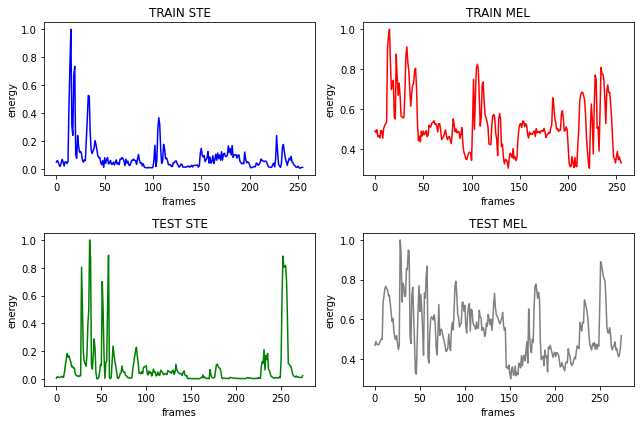

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(train_ste, 'blue')
plt.title("TRAIN STE")
plt.xlabel('frames')
plt.ylabel('energy')

plt.subplot(2, 2, 2)
plt.plot(train_mel, 'red')
plt.title("TRAIN MEL")
plt.xlabel('frames')
plt.ylabel('energy')

plt.subplot(2, 2, 3)
plt.plot(test_ste, 'green')
plt.title("TEST STE")
plt.xlabel('frames')
plt.ylabel('energy')

plt.subplot(2, 2, 4)
plt.plot(test_mel, 'gray')
plt.title("TEST MEL")
plt.xlabel('frames')
plt.ylabel('energy')

plt.tight_layout(rect=(0, 0, 1.5, 1.5))
plt.show()

### Some Useful functions for both STE and MEL

In [ ]:
def extract_features(val, gt):
  speech, nonspeech = [], []
  for i in range(len(gt)):
    if gt[i] == 1:
      speech.append(val[i])
    else:
      nonspeech.append(val[i])
  return np.array(speech), np.array(nonspeech)

In [ ]:
def pdf(x, mean, sd):
  f1 = 1/(sd*np.sqrt(2*np.pi))
  f2 = ((x-mean)/sd)**2
  f3 = np.exp(-0.5*f2)
  prob = f1*f3
  return prob

In [ ]:
def scores(y, y_pred):
  TP, FP, TN, FN = 0, 0, 0, 0
  for i in range(len(y)):
    if y[i] == 1 and y_pred[i] == 1:
      TP+=1
    elif y[i] == 0 and y_pred[i] == 1:
      FP+=1
    elif y[i] == 0 and y_pred[i] == 0:
      TN+= 1
    elif y[i] == 1 and y_pred[i] == 0:
      FN+=1
  return TP, FP, TN, FN

In [ ]:
def sensitivity(TP, FN):
  return TP/(TP+FN)

def specificity(TN, FP):
  return TN/(TN+FP)

## **STE Based Detection**

In [ ]:
ste_speech, ste_nonspeech = extract_features(train_ste[0], train_gt[0])

### Maximum Likelihood Estimate

In [ ]:
ste_mean_s = np.mean(ste_speech)
ste_mean_ns = np.mean(ste_nonspeech)

ste_var_s = np.var(ste_speech)
ste_var_ns = np.var(ste_nonspeech)

print('Speech:\nmean = {}\nvariance = {}'.format(ste_mean_s, ste_var_s))
print('Non Speech:\nmean = {}\nvariance = {}'.format(ste_mean_ns, ste_var_ns))

Speech:
mean = 0.12043432332432433
variance = 0.027681259243278893
Non Speech:
mean = 0.053090674108275865
variance = 0.0012944035189149682


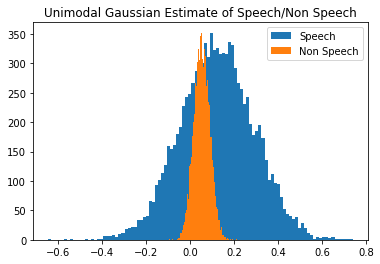

In [ ]:
ste_plot_s = np.random.normal(ste_mean_s, np.sqrt(ste_var_s), 10000)
ste_plot_ns = np.random.normal(ste_mean_ns, np.sqrt(ste_var_ns), 10000)

plt.hist(ste_plot_s, bins=100)
plt.hist(ste_plot_ns, bins=100)

plt.title('Unimodal Gaussian Estimate of Speech/Non Speech')
plt.legend(['Speech', 'Non Speech'])
plt.show()

### Testing Phase

In [ ]:
p = []
for xi in test_ste[0]:
  p.append(pdf(xi, ste_mean_s, np.sqrt(ste_var_s)))

min, max = np.min(p), np.max(p)
min, max

(2.0463809110477467e-06, 2.3978121781224004)

In [ ]:
threshold = np.random.uniform(min, max, size=(100,))
threshold = sorted(threshold)

### Results

In [ ]:
TP, FP, TN, FN = [], [], [], []
for t in threshold:
  y_predicted = [1 if i > t else 0 for i in p]
  w, x, y, z = scores(test_gt[0], y_predicted)
  TP.append(w)
  FP.append(x)
  TN.append(y)
  FN.append(z)

In [ ]:
print('CONFUSION MATRIX')
print([[TP[10], FP[10]],[FN[10], TN[10]]])

CONFUSION MATRIX
[[146, 117], [12, 0]]


In [ ]:
TPR, FPR = [], []
for i in range(len(threshold)):
  TPR.append(sensitivity(TP[i], FN[i]))
  FPR.append(1 - specificity(TN[i], FP[i]))

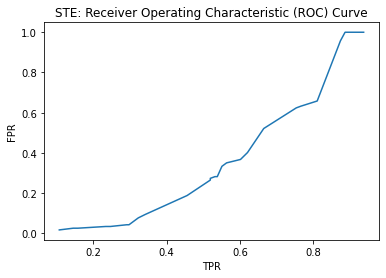

In [ ]:
plt.plot(TPR, FPR)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('STE: Receiver Operating Characteristic (ROC) Curve')
plt.show()

## **MEL Energy Based Detection**

In [ ]:
mel_speech, mel_nonspeech = extract_features(train_mel[0], train_gt[0])

### Maximum Likelihood Estimation

In [ ]:
mel_mean_s = np.mean(mel_speech)
mel_mean_ns = np.mean(mel_nonspeech)

mel_var_s = np.var(mel_speech)
mel_var_ns = np.var(mel_nonspeech)

print('Speech:\nmean = {}\nvariance = {}'.format(mel_mean_s, mel_var_s))
print('Non Speech:\nmean = {}\nvariance = {}'.format(mel_mean_ns, mel_var_ns))

Speech:
mean = 0.6100466456738739
variance = 0.022868307223842404
Non Speech:
mean = 0.45865463603448275
variance = 0.005185428144146614


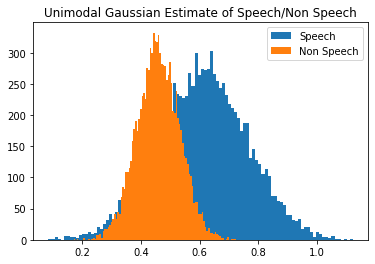

In [ ]:
mel_plot_s = np.random.normal(mel_mean_s, np.sqrt(mel_var_s), 10000)
mel_plot_ns = np.random.normal(mel_mean_ns, np.sqrt(mel_var_ns), 10000)

plt.hist(mel_plot_s, bins=100)
plt.hist(mel_plot_ns, bins=100)

plt.title('Unimodal Gaussian Estimate of Speech/Non Speech')
plt.legend(['Speech', 'Non Speech'])
plt.show()

### Testing Phase

In [ ]:
p_mel = []
for xi in test_mel[0]:
  p_mel.append(pdf(xi, mel_mean_s, np.sqrt(mel_var_s)))

min_mel, max_mel = np.min(p_mel), np.max(p_mel)
min_mel, max_mel

(0.09492154312068739, 2.638105916310276)

In [ ]:
threshold_mel = np.random.uniform(min_mel, max_mel, size=(100,))
threshold_mel = sorted(threshold_mel)

### Results

In [ ]:
TP_mel, FP_mel, TN_mel, FN_mel = [], [], [], []
for t in threshold_mel:
  y_predicted = [1 if i > t else 0 for i in p_mel]
  w, x, y, z = scores(test_gt[0], y_predicted)
  TP_mel.append(w)
  FP_mel.append(x)
  TN_mel.append(y)
  FN_mel.append(z)

In [ ]:
print('CONFUSION MATRIX')
print([[TP_mel[10], FP_mel[10]],[FN_mel[10], TN_mel[10]]])

CONFUSION MATRIX
[[154, 110], [4, 7]]


In [ ]:
TPR_mel, FPR_mel = [], []
for i in range(len(threshold_mel)):
  TPR_mel.append(sensitivity(TP_mel[i], FN_mel[i]))
  FPR_mel.append(1 - specificity(TN_mel[i], FP_mel[i]))

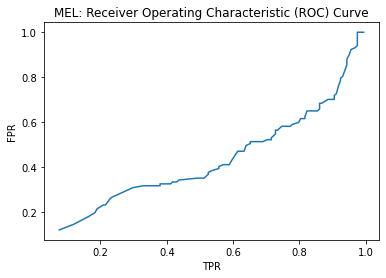

In [ ]:
plt.plot(TPR_mel, FPR_mel)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('MEL: Receiver Operating Characteristic (ROC) Curve')
plt.show()

## Concluding Results (STE vs MEL)

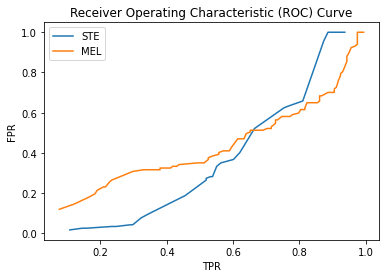

In [ ]:
plt.plot(TPR, FPR)
plt.plot(TPR_mel, FPR_mel)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(['STE', 'MEL'])
plt.show()

In [ ]:
#scale prob 0 to 1